In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
 
from matplotlib import pyplot as plt
 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

# Загружаем данные и проводим EDA.

In [2]:
# CRIM     уровень преступности на душу населения 
# ZN       доля жилой земли, зонированной на участки площадью более 25 000 кв.футов.
# INDUS    доля акров, не связанных с розничной торговлей, на город
# CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
# NOX      концентрация оксидов азота (частей на 10 миллионов)
# RM       среднее количество комнат в жилом помещении
# AGE      доля жилых помещений, занятых владельцами, построенных до 1940 года
# DIS      взвешенные расстояния до пяти бостонских центров занятости
# RAD      индекс доступности к радиальным магистралям
# TAX      ставка налога на недвижимость с полной стоимостью за $10,000
# PTRATIO  соотношение учащихся и учителей по городам
# B        1000(Bk - 0.63)^2 где Bk - доля чернокожих по городам
# LSTAT    % населения низкого статуса
# MEDV     Средняя стоимость домов, занятых владельцами, в 1000 долларов

columns_name = ['CRIM',
                'ZN',
                'INDUS',
                'CHAS',
                'NOX',
                'RM',
                'AGE',
                'DIS',
                'RAD',
                'TAX',
                'PTRATIO',
                'B',
                'LSTAT',
                'MEDV']

In [3]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
# target = raw_df.values[1::2, 2]

In [4]:
estate = pd.DataFrame(data, columns=columns_name)

Выбрасываем из данных все признаки кроме RM, LSTAT и целевого признака MEDV.

In [5]:
estate.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [6]:
estate.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B'], axis=1, inplace=True)

In [7]:
estate.sample(5)

,RM,LSTAT,MEDV
34,6.096,20.34,13.5
215,6.182,9.47,25.0
98,7.820,3.57,43.8
222,6.879,9.93,27.5
494,5.926,13.59,24.5


In [8]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RM      506 non-null    float64
 1   LSTAT   506 non-null    float64
 2   MEDV    506 non-null    float64
dtypes: float64(3)
memory usage: 12.0 KB


In [9]:
estate.describe()

,RM,LSTAT,MEDV
count,506.000000,506.000000,506.000000
mean,6.284634,12.653063,22.532806
std,0.702617,7.141062,9.197104
min,3.561000,1.730000,5.000000
25%,5.885500,6.950000,17.025000
50%,6.208500,11.360000,21.200000
75%,6.623500,16.955000,25.000000
max,8.780000,37.970000,50.000000


Посмотрим как данные распределены.

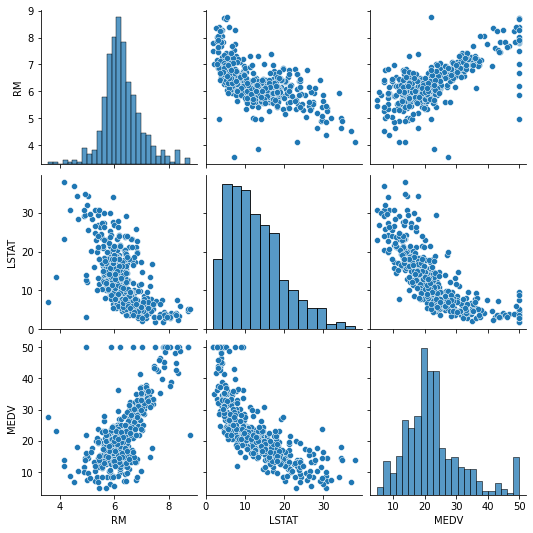

In [10]:
sns.pairplot(estate[['RM','LSTAT','MEDV']])
# plt.hist(estate['TAX'])

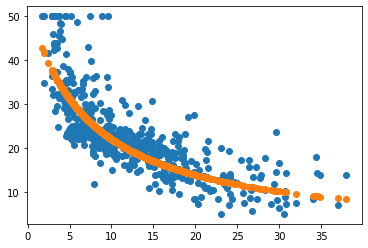

In [11]:
# Преобразуем некоторые признаки в линейные.
yy = np.array(1/estate['MEDV'])
xx = np.array(estate['LSTAT'])
A = np.vstack([xx, np.ones(len(xx))]).T
k, b = np.linalg.lstsq(A, yy, rcond=None)[0]
k, b
YY = 1/(k*xx + b)
plt.scatter(estate['LSTAT'], estate['MEDV'])
plt.scatter(xx, YY)
estate['LIN_LSTAT'] = estate['LSTAT'].map(lambda x: 1/(k*x+b))

In [12]:
estate.sample(3)

,RM,LSTAT,MEDV,LIN_LSTAT
310,4.973,12.64,16.1,19.051077
337,5.895,10.56,18.5,21.304739
314,6.567,9.28,23.8,22.977436


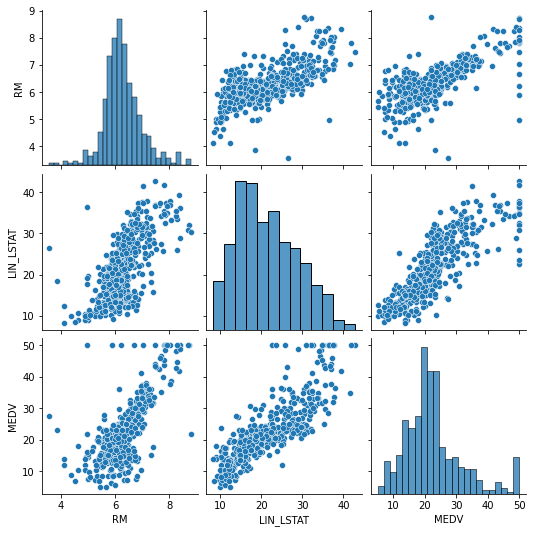

In [13]:
sns.pairplot(estate[['RM','LIN_LSTAT', 'MEDV']])

{'whiskers': [<matplotlib.lines.Line2D at 0x1247ad3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1247ada30>,
 'boxes': [<matplotlib.lines.Line2D at 0x12479ff40>],
 'medians': [<matplotlib.lines.Line2D at 0x1247b6190>],
 'fliers': [<matplotlib.lines.Line2D at 0x1247b6520>],
 'means': []}

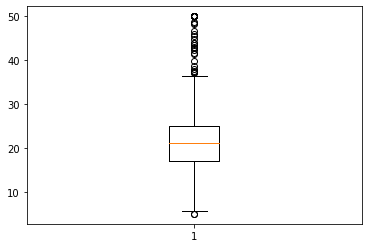

In [14]:
plt.boxplot(estate['MEDV'])

In [15]:
q25 = estate['MEDV'].quantile(0.25)
q75 = estate['MEDV'].quantile(0.75)
out_left = q25 - 1.5 * (q75 - q25)
out_right = q75 + 1.5 * (q75 - q25)

estate_filter = estate.loc[ (estate['MEDV'] > out_left) & (estate['MEDV'] < out_right) ]

In [16]:
estate_filter.sample(5)
# plt.boxplot(estate_filter['MEDV'])

,RM,LSTAT,MEDV,LIN_LSTAT
110,6.195,13.00,21.7,18.708552
208,6.064,14.66,24.4,17.276272
52,6.511,5.28,25.0,30.447925
178,6.860,6.92,29.9,26.866598
442,6.219,16.59,18.4,15.864204


In [17]:
# Добавим категорию цены для классификатора.

cut_labels = ['A', 'B', 'C']
cut_bins = list(range(0, 48, 12))
estate_filter['MEDV_BIN'] = pd.cut(estate_filter['MEDV'], bins=cut_bins, labels=cut_labels)

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
estate_filter['MEDV_BIN'] = LE.fit_transform(estate_filter['MEDV_BIN'])

<ipython-input-17-98beac5402d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estate_filter['MEDV_BIN'] = pd.cut(estate_filter['MEDV'], bins=cut_bins, labels=cut_labels)
<ipython-input-17-98beac5402d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estate_filter['MEDV_BIN'] = LE.fit_transform(estate_filter['MEDV_BIN'])


In [18]:
X = estate_filter[['RM', 'LIN_LSTAT']]

In [19]:
y = estate_filter['MEDV']

In [20]:
print(X.shape, y.shape)

(466, 2) (466,)


# Decision Tree

## Decision Tree Regressor


In [21]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit_transform(X, y)

In [22]:
X.columns

Index(['RM', 'LIN_LSTAT'], dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=81453)

In [24]:
model_reg = DecisionTreeRegressor(max_depth=2)

In [25]:
model_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [26]:
predict = model_reg.predict(X_test)

In [27]:
model_reg.score(X_test, y_test)

0.6130238930975196

### Рисуем схемы и графики

In [28]:
from sklearn import tree

In [29]:
text_representation = tree.export_text(model_reg)
print(text_representation)

|--- feature_1 <= 22.38
|   |--- feature_1 <= 16.96
|   |   |--- value: [14.86]
|   |--- feature_1 >  16.96
|   |   |--- value: [20.55]
|--- feature_1 >  22.38
|   |--- feature_0 <= 6.55
|   |   |--- value: [22.99]
|   |--- feature_0 >  6.55
|   |   |--- value: [29.87]



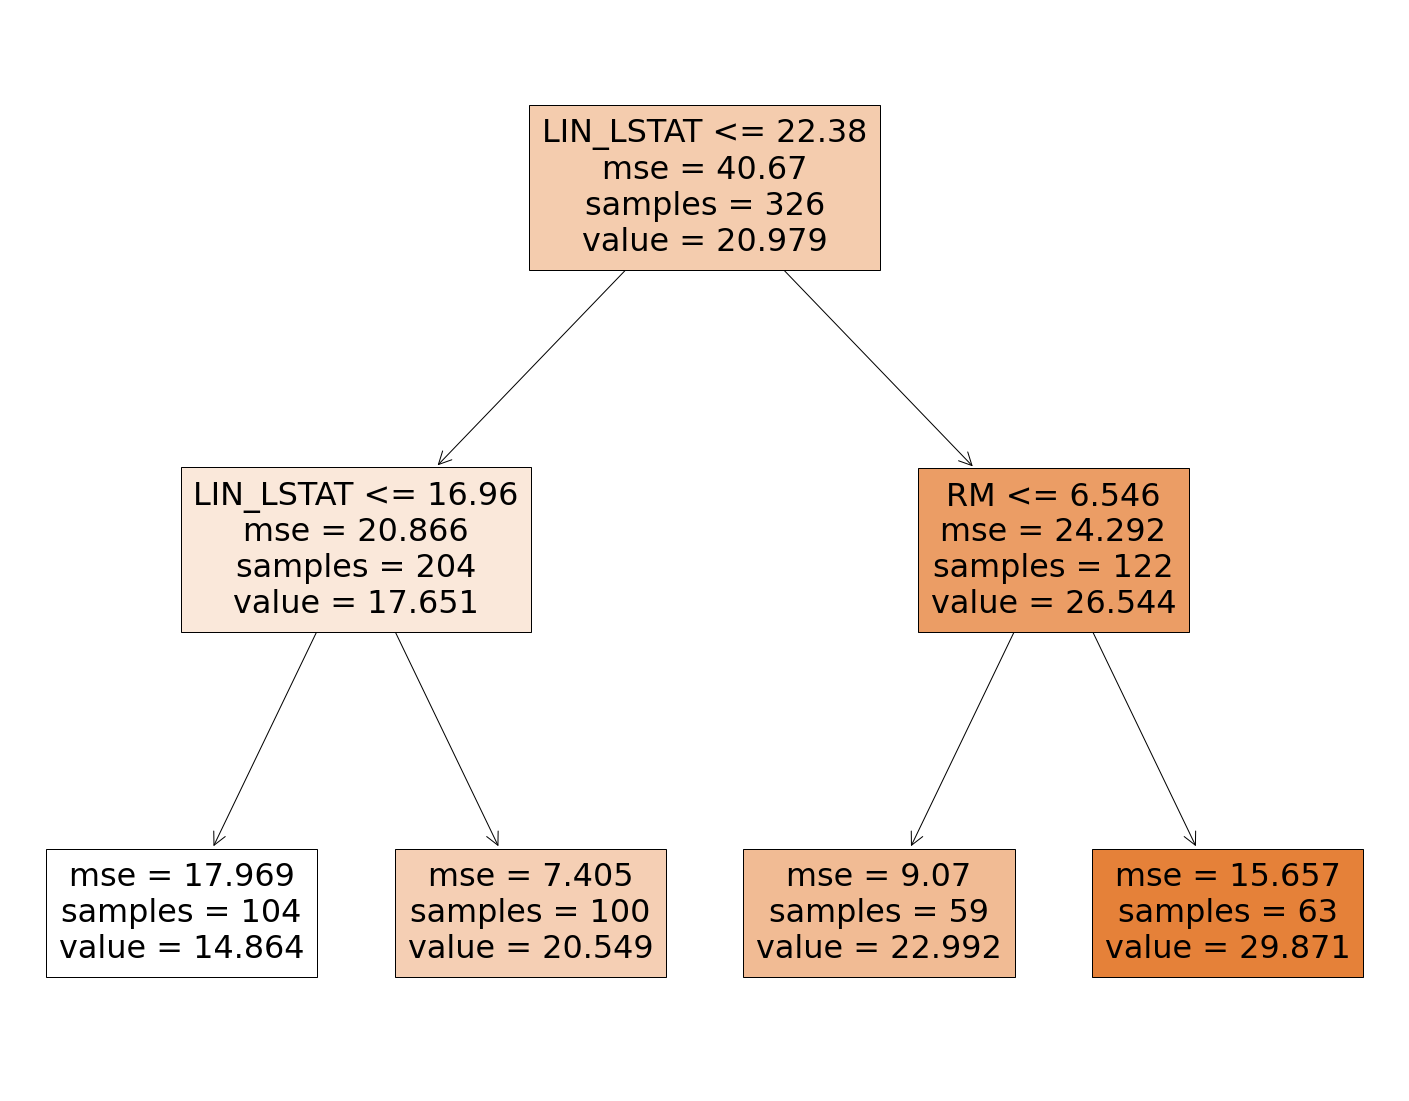

In [30]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_reg, feature_names=X.columns, filled=True)

In [31]:
from dtreeviz.trees import *

In [32]:
viz = dtreeviz(model_reg, X, y, target_name="MEDV", feature_names=X.columns)

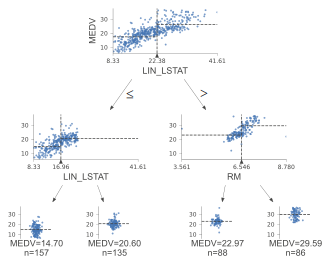

In [33]:
viz

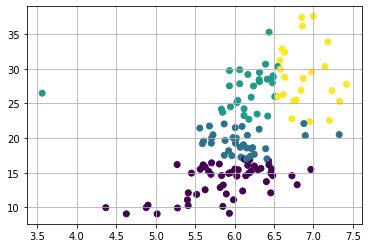

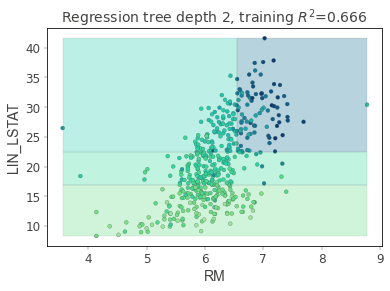

In [34]:
plt.scatter(X_test['RM'], X_test['LIN_LSTAT'], c=predict)
plt.grid()

rtreeviz_bivar_heatmap(model_reg, X, y, feature_names=['RM', 'LIN_LSTAT'], fontsize=14)
plt.show()

## Desicion Tree Classifier

In [35]:
y_class = estate_filter['MEDV_BIN']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3, random_state=81453)

In [37]:
y_train.sample(5)

78     1
82     2
360    2
487    1
164    1
Name: MEDV_BIN, dtype: int64

In [38]:
model_class = DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [39]:
model_class.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [40]:
predict_class = model_class.predict(X_test)

In [41]:
predict_class

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [42]:
model_class.score(X_test, y_test)

0.6857142857142857

In [43]:
text_representation = tree.export_text(model_class)
print(text_representation)

|--- feature_1 <= 22.61
|   |--- feature_1 <= 14.00
|   |   |--- class: 1
|   |--- feature_1 >  14.00
|   |   |--- class: 1
|--- feature_1 >  22.61
|   |--- feature_0 <= 6.61
|   |   |--- class: 1
|   |--- feature_0 >  6.61
|   |   |--- class: 2



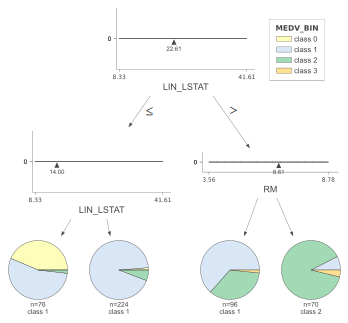

In [44]:
viz_class = dtreeviz(model_class, X, y, target_name="MEDV_BIN", feature_names=X.columns)
viz_class

### Рисуем график

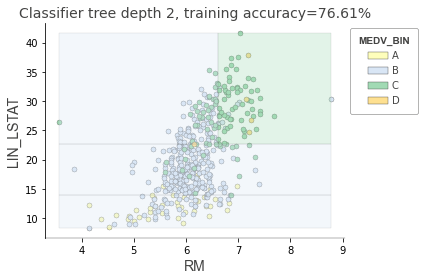

In [45]:
class_names = ['A', 'B', 'C', 'D']
ctreeviz_bivar(model_class, X, y_class,
                    feature_names = ['RM', 'LIN_LSTAT'],
                    class_names=class_names,
                    target_name='MEDV_BIN')
plt.tight_layout()
plt.show()


# Linear Regression

Сравним полученные результаты с моделью линейной регрессии.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=81453)

In [47]:
model_linreg = LinearRegression()

In [48]:
model_linreg.fit(X_train, y_train)
model_linreg.score(X_test, y_test)

0.5851665621305604

In [49]:
predict_linreg = model_linreg.predict(X_test)

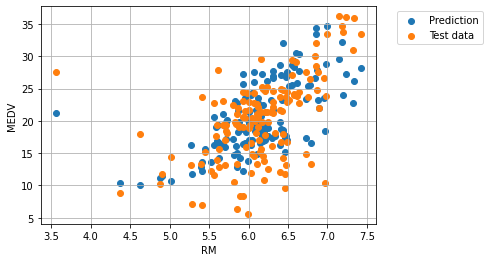

In [50]:
# plt.scatter(X_test['LIN_LSTAT'], y_test)
plt.scatter(X_test['RM'], predict_linreg, label='Prediction')
plt.scatter(X_test['RM'], y_test, label='Test data')
plt.grid()
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.legend(bbox_to_anchor=(1.05, 1))


В целом на этих данных (сильно укороченных) все модели работают хорошо. Score ~60%. Но, если для деревьев решений увеличить параметр max_depth с 2 до 3, оценка возростает до 70%. 